# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

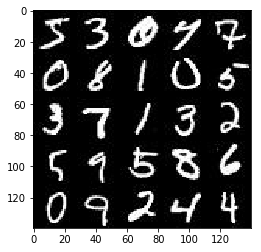

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

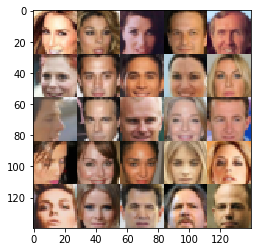

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,(None, image_width , image_height , image_channels), name='input_real')
    
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        # hidden layer              
        alpha=0.01    
        keep_prob=0.8  
        h1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer()) 
        # Leaky Relu
        relu1 = tf.maximum(alpha * h1, h1)   
        # dropout layer
        drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob) 
        # 14 *14 *128
        
        h2 = tf.layers.conv2d(drop1, 256, 5,strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(h2)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob= keep_prob)
        # 7*7 *256
        
        h3 = tf.layers.conv2d(drop2, 512, 5,strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(h3)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob= keep_prob)
        # 4*4 *512
        
        # flatten it
        flat = tf.reshape(drop3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function  
   
    with tf.variable_scope('generator', reuse=not is_train): 
        
        # hidden layer 
        n_units = 4* 4* 512 
        alpha = 0.01
        h1 = tf.layers.dense(z, n_units, activation=None)  
        # reshape it to start the convolutional stack
        h1 = tf.reshape(h1, (-1, 4, 4, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        # leaky ReLU
        relu1 = tf.maximum(alpha * h1, h1)  
        # 4*4*512 now
        
        h2 = tf.layers.conv2d_transpose(relu1, 256, 4, strides=1, padding='valid',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        relu2 = tf.maximum(alpha * h2,h2)
        # 7*7*256
        
        h2 = tf.layers.conv2d_transpose(relu2, 128, 4, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        relu3 = tf.maximum(alpha * h2,h2)
        # 14* 14 *128 now
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 4, strides=2, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28 * 28 * out_channel_dim now
        
        output = tf.tanh(logits)
        
        return output   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function 
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)           
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1- smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss  


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'  
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model     
     
    # tf.reset_default_graph()
    
    # create input placeholder  
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)  
    
    # model_loss
    out_channel_dim = data_shape[3]
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)   
      
    # model_opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
 
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # 1，获得图像
                steps += 1
                #通过reshape()展开成张量,并缩放
                batch_iamnge =  batch_images.reshape(batch_size, data_shape[1]* data_shape[2]* data_shape[3])
                batch_images = batch_images*2
                
                # 2. Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
               
                # 3. Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,input_real: batch_images, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,input_real: batch_images, lr:learning_rate})
        
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))               

                if steps % 100 == 0:
                    show_generator_output(sess, 30, input_z, data_shape[3], data_image_mode)

      

                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.4173... Generator Loss: 0.6127
Epoch 1/2... Discriminator Loss: 1.4457... Generator Loss: 0.5825
Epoch 1/2... Discriminator Loss: 1.3332... Generator Loss: 0.7783
Epoch 1/2... Discriminator Loss: 1.2905... Generator Loss: 0.8021
Epoch 1/2... Discriminator Loss: 1.3209... Generator Loss: 0.7200
Epoch 1/2... Discriminator Loss: 1.2579... Generator Loss: 0.8596
Epoch 1/2... Discriminator Loss: 1.4462... Generator Loss: 0.7410
Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 0.6766
Epoch 1/2... Discriminator Loss: 1.3489... Generator Loss: 0.7639
Epoch 1/2... Discriminator Loss: 1.2325... Generator Loss: 0.8311


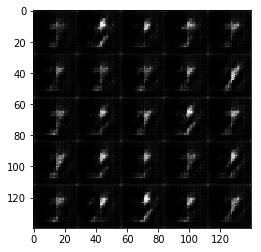

Epoch 1/2... Discriminator Loss: 1.3157... Generator Loss: 0.7100
Epoch 1/2... Discriminator Loss: 1.4174... Generator Loss: 0.7446
Epoch 1/2... Discriminator Loss: 1.5651... Generator Loss: 1.6279
Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 0.8223
Epoch 1/2... Discriminator Loss: 1.2332... Generator Loss: 0.9237
Epoch 1/2... Discriminator Loss: 1.4122... Generator Loss: 0.8083
Epoch 1/2... Discriminator Loss: 1.1536... Generator Loss: 0.9151
Epoch 1/2... Discriminator Loss: 1.1778... Generator Loss: 1.0108
Epoch 1/2... Discriminator Loss: 1.2406... Generator Loss: 0.6845
Epoch 1/2... Discriminator Loss: 1.0970... Generator Loss: 0.9261


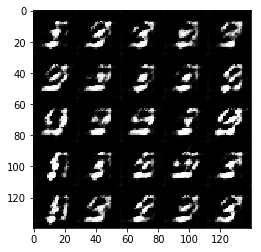

Epoch 1/2... Discriminator Loss: 1.3734... Generator Loss: 1.0031
Epoch 1/2... Discriminator Loss: 0.9609... Generator Loss: 1.1484
Epoch 1/2... Discriminator Loss: 1.1244... Generator Loss: 1.0602
Epoch 1/2... Discriminator Loss: 1.0451... Generator Loss: 1.0381
Epoch 1/2... Discriminator Loss: 1.3316... Generator Loss: 0.8945
Epoch 1/2... Discriminator Loss: 0.9570... Generator Loss: 0.9879
Epoch 1/2... Discriminator Loss: 1.3142... Generator Loss: 0.9489
Epoch 1/2... Discriminator Loss: 1.3087... Generator Loss: 0.8011
Epoch 1/2... Discriminator Loss: 1.4853... Generator Loss: 0.6296
Epoch 1/2... Discriminator Loss: 1.6282... Generator Loss: 0.8590


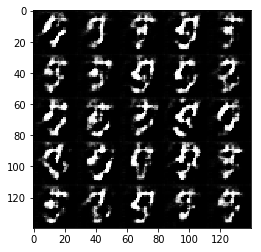

Epoch 1/2... Discriminator Loss: 1.3058... Generator Loss: 0.7439
Epoch 1/2... Discriminator Loss: 1.3233... Generator Loss: 0.8702
Epoch 1/2... Discriminator Loss: 1.3131... Generator Loss: 0.6923
Epoch 1/2... Discriminator Loss: 1.2523... Generator Loss: 0.8674
Epoch 1/2... Discriminator Loss: 1.2701... Generator Loss: 0.8675
Epoch 1/2... Discriminator Loss: 1.3192... Generator Loss: 0.9482
Epoch 1/2... Discriminator Loss: 1.6089... Generator Loss: 0.7045
Epoch 1/2... Discriminator Loss: 1.2143... Generator Loss: 0.8955
Epoch 1/2... Discriminator Loss: 1.5419... Generator Loss: 0.7156
Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 0.8689


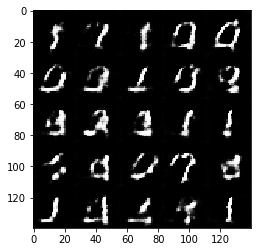

Epoch 1/2... Discriminator Loss: 1.4298... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.8499
Epoch 1/2... Discriminator Loss: 1.4224... Generator Loss: 0.7581
Epoch 1/2... Discriminator Loss: 1.3543... Generator Loss: 0.7141
Epoch 1/2... Discriminator Loss: 1.3876... Generator Loss: 0.8193
Epoch 1/2... Discriminator Loss: 1.3019... Generator Loss: 0.8024
Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 0.7766
Epoch 1/2... Discriminator Loss: 1.2996... Generator Loss: 0.7780
Epoch 1/2... Discriminator Loss: 1.2937... Generator Loss: 0.8058
Epoch 1/2... Discriminator Loss: 1.3572... Generator Loss: 0.7927


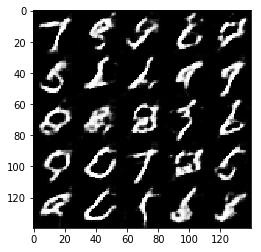

Epoch 1/2... Discriminator Loss: 1.5197... Generator Loss: 0.7232
Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 0.8578
Epoch 1/2... Discriminator Loss: 1.4582... Generator Loss: 0.7366
Epoch 1/2... Discriminator Loss: 1.2233... Generator Loss: 0.7840
Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 0.8354
Epoch 1/2... Discriminator Loss: 1.4031... Generator Loss: 0.8139
Epoch 1/2... Discriminator Loss: 1.4912... Generator Loss: 0.7579
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 0.8017
Epoch 1/2... Discriminator Loss: 1.3332... Generator Loss: 0.8256
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.7601


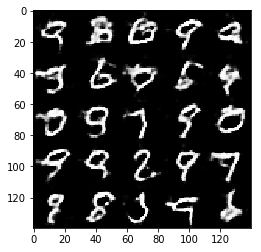

Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 0.7532
Epoch 1/2... Discriminator Loss: 1.3692... Generator Loss: 0.7973
Epoch 1/2... Discriminator Loss: 1.3688... Generator Loss: 0.7716
Epoch 1/2... Discriminator Loss: 1.3951... Generator Loss: 0.7689
Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 0.8141
Epoch 1/2... Discriminator Loss: 1.3394... Generator Loss: 0.7708
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.8110
Epoch 1/2... Discriminator Loss: 1.4554... Generator Loss: 0.6751
Epoch 1/2... Discriminator Loss: 1.3185... Generator Loss: 0.7798
Epoch 1/2... Discriminator Loss: 1.4733... Generator Loss: 0.7764


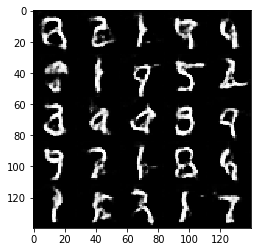

Epoch 1/2... Discriminator Loss: 1.4359... Generator Loss: 0.7638
Epoch 1/2... Discriminator Loss: 1.3761... Generator Loss: 0.7332
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.7326
Epoch 1/2... Discriminator Loss: 1.3431... Generator Loss: 0.7815
Epoch 1/2... Discriminator Loss: 1.3986... Generator Loss: 0.7296
Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 0.7466
Epoch 1/2... Discriminator Loss: 1.3694... Generator Loss: 0.7989
Epoch 1/2... Discriminator Loss: 1.4114... Generator Loss: 0.6760
Epoch 1/2... Discriminator Loss: 1.3644... Generator Loss: 0.8260
Epoch 1/2... Discriminator Loss: 1.3547... Generator Loss: 0.7881


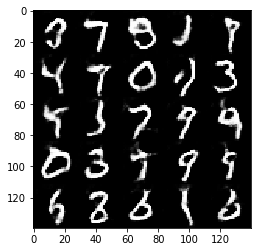

Epoch 1/2... Discriminator Loss: 1.3390... Generator Loss: 0.7451
Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 0.8157
Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 0.8662
Epoch 1/2... Discriminator Loss: 1.3627... Generator Loss: 0.6944
Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 0.8531
Epoch 1/2... Discriminator Loss: 1.3869... Generator Loss: 0.7063
Epoch 1/2... Discriminator Loss: 1.3952... Generator Loss: 0.8450
Epoch 1/2... Discriminator Loss: 1.3523... Generator Loss: 0.8028
Epoch 1/2... Discriminator Loss: 1.3353... Generator Loss: 0.7221
Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 0.7738


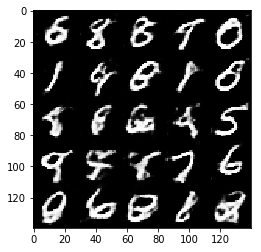

Epoch 1/2... Discriminator Loss: 1.3937... Generator Loss: 0.8013
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.8078
Epoch 1/2... Discriminator Loss: 1.4070... Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 1.2937... Generator Loss: 0.8001
Epoch 2/2... Discriminator Loss: 1.4228... Generator Loss: 0.8288
Epoch 2/2... Discriminator Loss: 1.3845... Generator Loss: 0.7298
Epoch 2/2... Discriminator Loss: 1.4157... Generator Loss: 0.7546
Epoch 2/2... Discriminator Loss: 1.3697... Generator Loss: 0.7685
Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 0.7683
Epoch 2/2... Discriminator Loss: 1.3606... Generator Loss: 0.7908


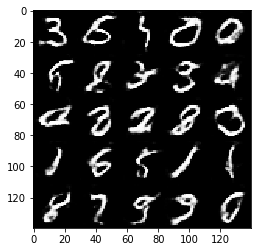

Epoch 2/2... Discriminator Loss: 1.3369... Generator Loss: 0.8551
Epoch 2/2... Discriminator Loss: 1.3651... Generator Loss: 0.8429
Epoch 2/2... Discriminator Loss: 1.3058... Generator Loss: 0.8081
Epoch 2/2... Discriminator Loss: 1.3845... Generator Loss: 0.7367
Epoch 2/2... Discriminator Loss: 1.3886... Generator Loss: 0.8112
Epoch 2/2... Discriminator Loss: 1.3981... Generator Loss: 0.7661
Epoch 2/2... Discriminator Loss: 1.4661... Generator Loss: 0.6958
Epoch 2/2... Discriminator Loss: 1.3980... Generator Loss: 0.8051
Epoch 2/2... Discriminator Loss: 1.3792... Generator Loss: 0.7553
Epoch 2/2... Discriminator Loss: 1.3718... Generator Loss: 0.7489


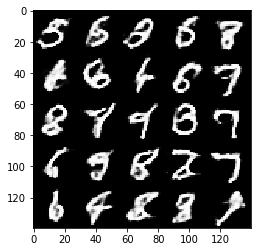

Epoch 2/2... Discriminator Loss: 1.3180... Generator Loss: 0.8163
Epoch 2/2... Discriminator Loss: 1.3073... Generator Loss: 0.8627
Epoch 2/2... Discriminator Loss: 1.3490... Generator Loss: 0.7447
Epoch 2/2... Discriminator Loss: 1.3106... Generator Loss: 0.7960
Epoch 2/2... Discriminator Loss: 1.4614... Generator Loss: 0.6393
Epoch 2/2... Discriminator Loss: 1.4557... Generator Loss: 0.7224
Epoch 2/2... Discriminator Loss: 1.3061... Generator Loss: 0.8340
Epoch 2/2... Discriminator Loss: 1.4534... Generator Loss: 0.7812
Epoch 2/2... Discriminator Loss: 1.3542... Generator Loss: 0.7594
Epoch 2/2... Discriminator Loss: 1.3744... Generator Loss: 0.7926


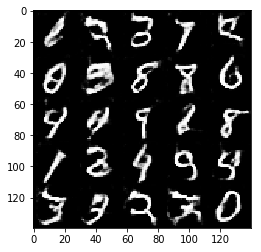

Epoch 2/2... Discriminator Loss: 1.3267... Generator Loss: 0.7721
Epoch 2/2... Discriminator Loss: 1.3392... Generator Loss: 0.7656
Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 0.8208
Epoch 2/2... Discriminator Loss: 1.3218... Generator Loss: 0.8390
Epoch 2/2... Discriminator Loss: 1.4706... Generator Loss: 0.6698
Epoch 2/2... Discriminator Loss: 1.4004... Generator Loss: 0.7791
Epoch 2/2... Discriminator Loss: 1.4502... Generator Loss: 0.6972
Epoch 2/2... Discriminator Loss: 1.3099... Generator Loss: 0.6555
Epoch 2/2... Discriminator Loss: 1.3890... Generator Loss: 0.8302
Epoch 2/2... Discriminator Loss: 1.3434... Generator Loss: 0.8751


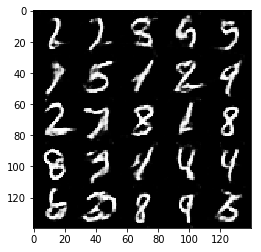

Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 0.9127
Epoch 2/2... Discriminator Loss: 1.4310... Generator Loss: 0.6579
Epoch 2/2... Discriminator Loss: 1.2885... Generator Loss: 0.8329
Epoch 2/2... Discriminator Loss: 1.3481... Generator Loss: 0.7590
Epoch 2/2... Discriminator Loss: 1.4124... Generator Loss: 0.8083
Epoch 2/2... Discriminator Loss: 1.3630... Generator Loss: 0.8029
Epoch 2/2... Discriminator Loss: 1.3840... Generator Loss: 0.7855
Epoch 2/2... Discriminator Loss: 1.3584... Generator Loss: 0.8036
Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 0.8080
Epoch 2/2... Discriminator Loss: 1.4054... Generator Loss: 0.8721


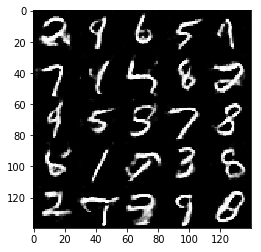

Epoch 2/2... Discriminator Loss: 1.4302... Generator Loss: 0.8399
Epoch 2/2... Discriminator Loss: 1.4101... Generator Loss: 0.7973
Epoch 2/2... Discriminator Loss: 1.4509... Generator Loss: 0.7234
Epoch 2/2... Discriminator Loss: 1.3546... Generator Loss: 0.8224
Epoch 2/2... Discriminator Loss: 1.3526... Generator Loss: 0.7995
Epoch 2/2... Discriminator Loss: 1.3133... Generator Loss: 0.7850
Epoch 2/2... Discriminator Loss: 1.4055... Generator Loss: 0.6947
Epoch 2/2... Discriminator Loss: 1.4335... Generator Loss: 0.7164
Epoch 2/2... Discriminator Loss: 1.3811... Generator Loss: 0.8768
Epoch 2/2... Discriminator Loss: 1.2784... Generator Loss: 0.9136


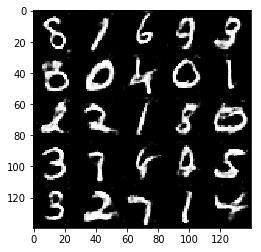

Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 0.6864
Epoch 2/2... Discriminator Loss: 1.3974... Generator Loss: 0.7468
Epoch 2/2... Discriminator Loss: 1.3662... Generator Loss: 0.7524
Epoch 2/2... Discriminator Loss: 1.3379... Generator Loss: 0.7976
Epoch 2/2... Discriminator Loss: 1.3199... Generator Loss: 0.7770
Epoch 2/2... Discriminator Loss: 1.3436... Generator Loss: 0.6856
Epoch 2/2... Discriminator Loss: 1.3909... Generator Loss: 0.7293
Epoch 2/2... Discriminator Loss: 1.3648... Generator Loss: 0.6686
Epoch 2/2... Discriminator Loss: 1.4332... Generator Loss: 0.7983
Epoch 2/2... Discriminator Loss: 1.3781... Generator Loss: 0.7267


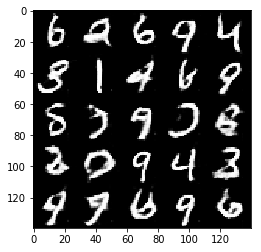

Epoch 2/2... Discriminator Loss: 1.3883... Generator Loss: 0.7239
Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 0.8033
Epoch 2/2... Discriminator Loss: 1.3597... Generator Loss: 0.7839
Epoch 2/2... Discriminator Loss: 1.3352... Generator Loss: 0.8974
Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 0.7401
Epoch 2/2... Discriminator Loss: 1.3220... Generator Loss: 0.8373
Epoch 2/2... Discriminator Loss: 1.3669... Generator Loss: 0.7183
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.7277
Epoch 2/2... Discriminator Loss: 1.4161... Generator Loss: 0.8098
Epoch 2/2... Discriminator Loss: 1.4358... Generator Loss: 0.6854


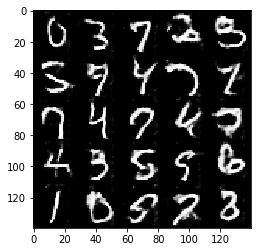

Epoch 2/2... Discriminator Loss: 1.3519... Generator Loss: 0.7492
Epoch 2/2... Discriminator Loss: 1.3869... Generator Loss: 0.7582
Epoch 2/2... Discriminator Loss: 1.3786... Generator Loss: 0.7551
Epoch 2/2... Discriminator Loss: 1.3352... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 1.3744... Generator Loss: 0.7403
Epoch 2/2... Discriminator Loss: 1.3511... Generator Loss: 0.8944
Epoch 2/2... Discriminator Loss: 1.3501... Generator Loss: 0.8071
Epoch 2/2... Discriminator Loss: 1.3956... Generator Loss: 0.7416
Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 0.7325
Epoch 2/2... Discriminator Loss: 1.3938... Generator Loss: 0.6358


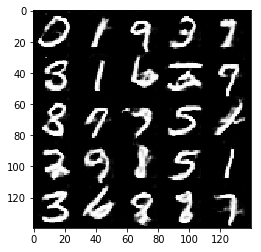

Epoch 2/2... Discriminator Loss: 1.3943... Generator Loss: 0.7600
Epoch 2/2... Discriminator Loss: 1.4208... Generator Loss: 0.7364
Epoch 2/2... Discriminator Loss: 1.3815... Generator Loss: 1.0257
Epoch 2/2... Discriminator Loss: 1.4068... Generator Loss: 0.7910
Epoch 2/2... Discriminator Loss: 1.4403... Generator Loss: 0.8278
Epoch 2/2... Discriminator Loss: 1.3727... Generator Loss: 0.7890
Epoch 2/2... Discriminator Loss: 1.3953... Generator Loss: 0.7323


In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.6939... Generator Loss: 0.7988


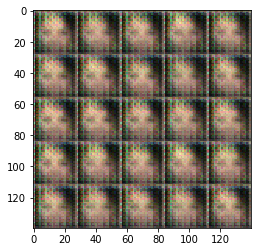

Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.8623... Generator Loss: 0.3939
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 1.2193
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.2269


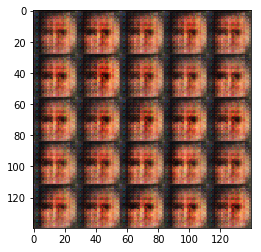

Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 1.6489
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 1.1759
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 1.1240


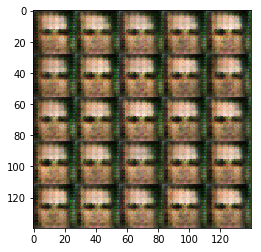

Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 1.5085
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 1.0190
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 1.2319


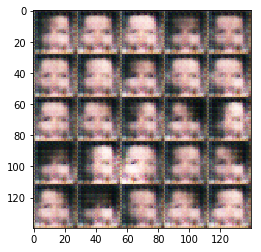

Epoch 1/1... Discriminator Loss: 0.8632... Generator Loss: 1.2774
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.9812
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 1.0622


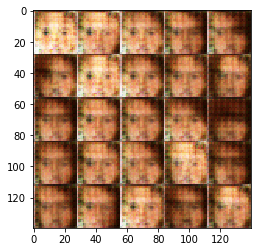

Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 1.2131
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.7892


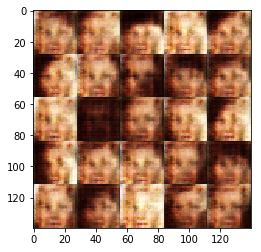

Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.7673


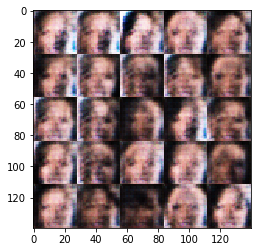

Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.8172


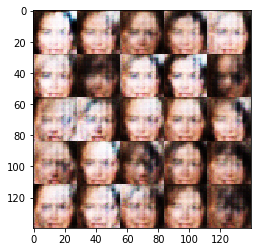

Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.8381


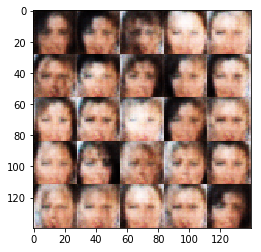

Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.8323


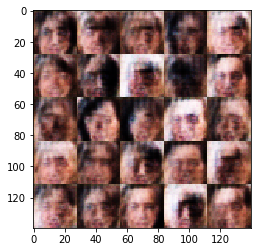

Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7920


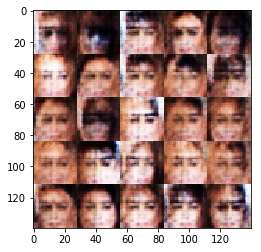

Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.8816


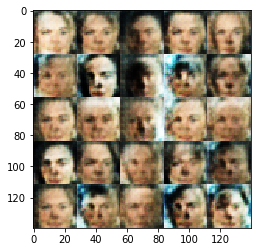

Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.8134


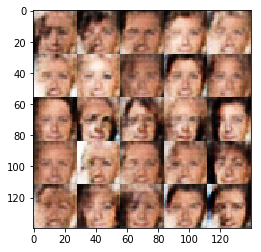

Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7472


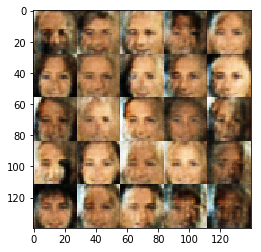

Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7840


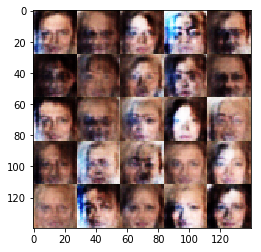

Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.8100


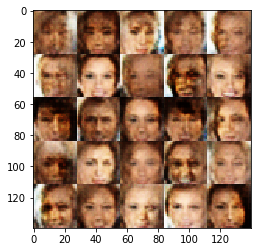

Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7447


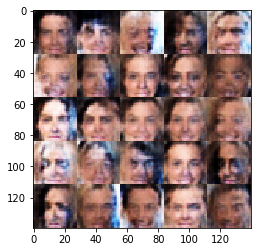

Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.7720


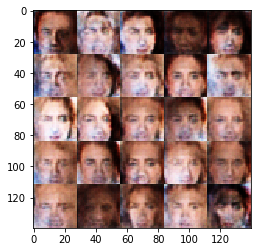

Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.8331


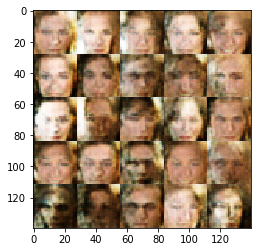

Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7365


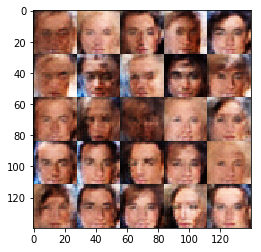

Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7701


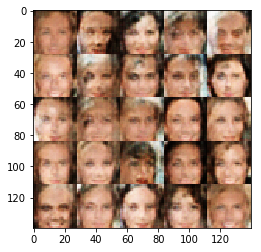

Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7868


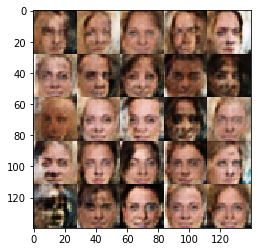

Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8007


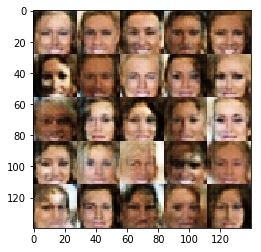

Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.7991


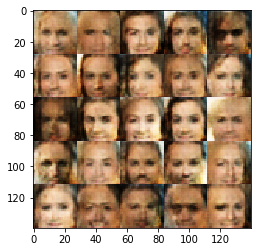

Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7554


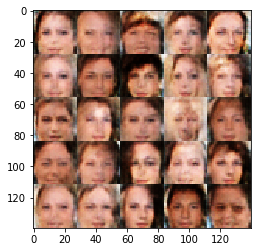

Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7707


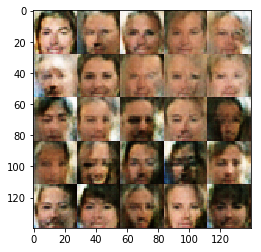

Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7745


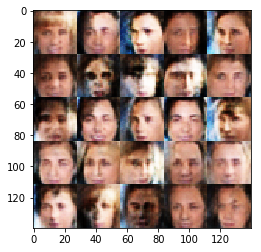

Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7415


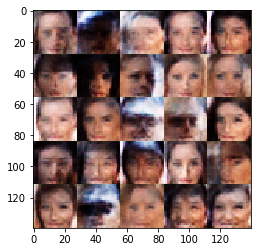

Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7442


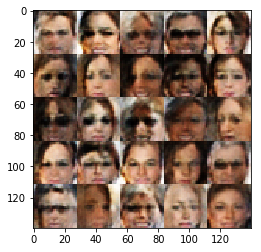

Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.8415


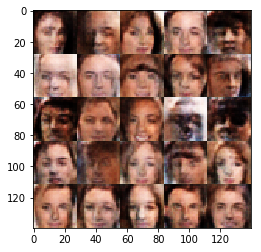

Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.8461


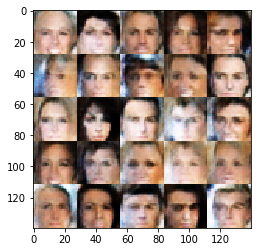

Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7737


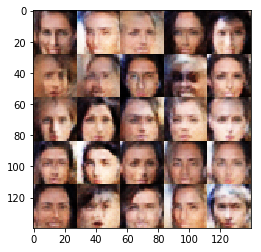

Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.7655


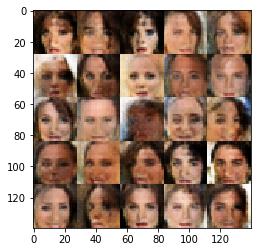

Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7674


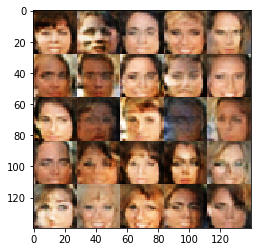

Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7932


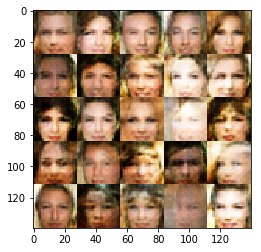

Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.6790


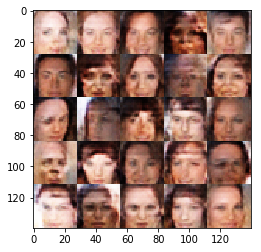

Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7576


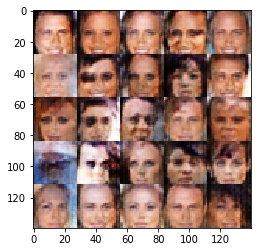

Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7261


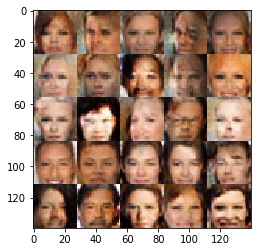

Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8277


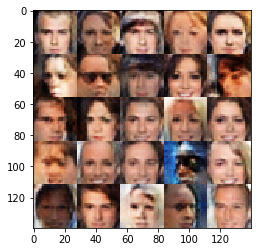

Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7511


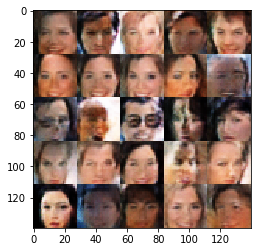

Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7795


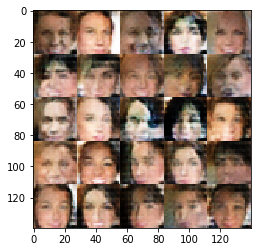

Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.7456


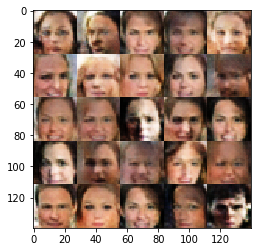

Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.9269


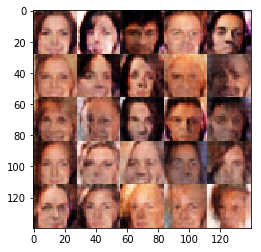

Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6325


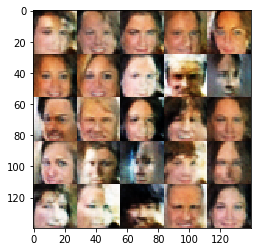

Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7788


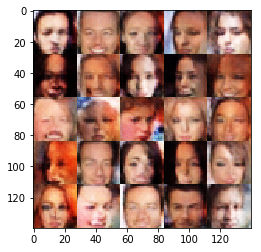

Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 1.0148
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7661


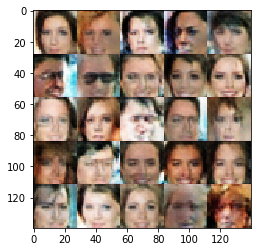

Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8250


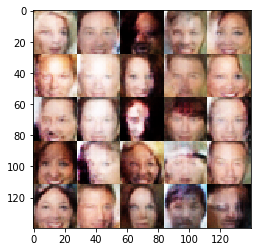

Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6752


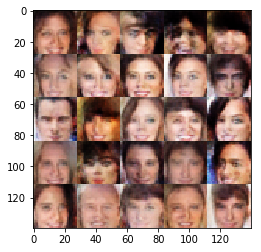

Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.6710


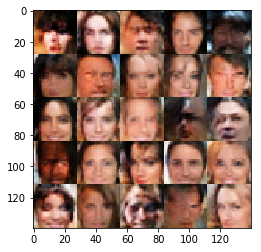

Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7446


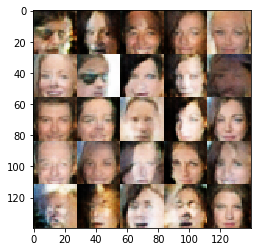

Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.8070


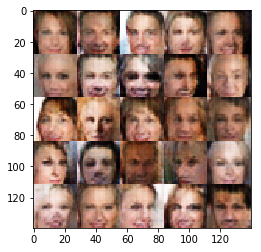

Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.7380


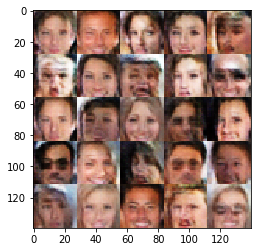

Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7659


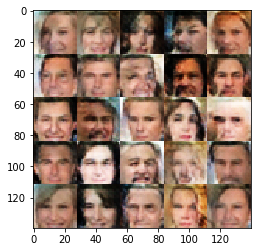

Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.7717


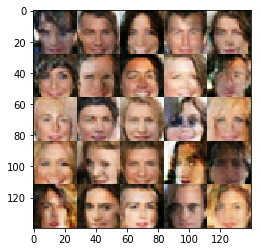

Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7081


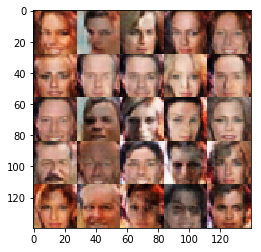

Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7698


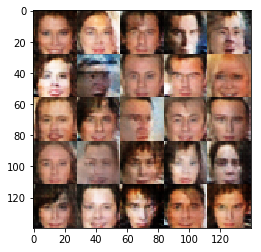

Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7223


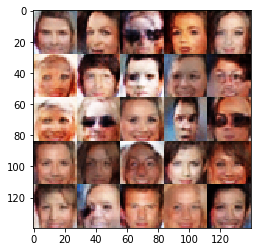

Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7721


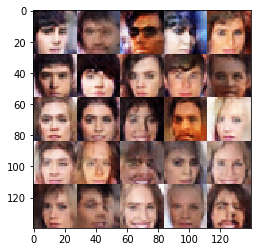

Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.8121


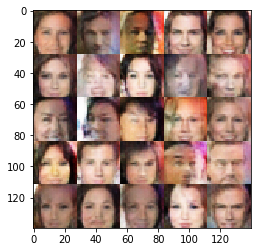

Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7726


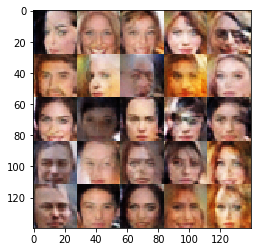

Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7791


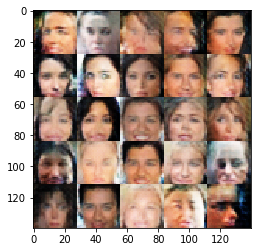

Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7276


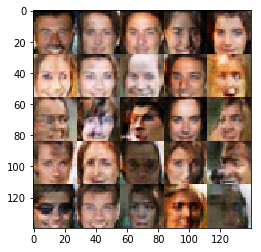

Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.7356


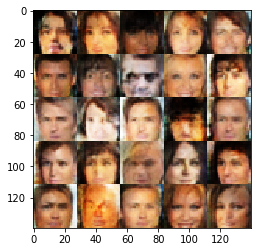

Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.7835


In [26]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。